# Assignment 3
- In this assignment, you will implement a melody-language model
- You have to submit your code in **TWO** formats:
    - Completed Notebook with `.ipynb`
    - A `{your_student_number}.py` file that includes **ALL functions and classes you have completed**
        - Do not include any other code except function and class
        - Your result will be scored by an evaluation code that import this `{your_student_number}.py` file
        - So be careful not to use any global variable inside the function
- You have to submit a report (optional) and **three** generation results of your favorite in wav files
    - The report is optional. If you have tried other architecture for MelodyLanguage Model, you can describe the result.


- Caution: The `assert` lines are designed to check whether basic requirements are satisfied. Even though you passed all the assert cases, it doesn't guarantee that your implementation is fully correct

In [2]:
import torch
import torch.nn as nn
torch.set_printoptions(sci_mode=False)

## 0. Prepare (Install and import library)

In [3]:
!pip install muspy
import muspy

muspy.download_bravura_font()
'''
You may have to install fluidsynth.
In Colab, you can install by followign code

!sudo apt-get install fluidsynth
'''
muspy.download_musescore_soundfont()

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Skip downloading as the Bravura font is found.
Skip downloading as the MuseScore General soundfont is found.


## Problem 1: Understanding and Implementing RNN (15 pts)
- Recurrent neural network is a typical choice for handling sequential data with a neural network
- In this problem, you have to implement a Vanilla RNN
    - For each time step $t$, RNN takes two inputs
        - $x_t$, which is an input vector of time step $t$
        - $h_{t-1}$, which is an hidden state of previous time step, $t-1$
            - $h_{t-1}$ is also the output of RNN for previous time step $t-1$
    - For given $x_t$ and $h_{t-1}$, RNN returns $h_t$
        - $h_t = \tanh(Wx_t + Uh_{t-1} + b)$ 
            - $W$ and $U$ is a trainable weight matrix of RNN
            - $W \in \mathbb{R}^{d \times h}$, and $U \in \mathbb{R}^{h \times h}$, where $d$ is number of input dimension and $h$ is number of hidden state dimension
                - This means that $W$ is a matrix with real numbers and size of $\text{num_input_dim}\times \text{num_hidden_dim}$  
                - and $U$ is a matrix with real numbers and size of $\text{num_hidden_dim}\times \text{num_hidden_dim}$  
            
 - The output of fully connected layer (`nn.Linear`) for a given input vector $x$ is as below:
     - $\text{output} = Wx+b$
     - Where $W$ is a weight matrix and $b$ is a bias vector
     - Both $W$ and $b$ are trainable parameters
 

### Problem 1.1: Calculating Forward Propagation of RNN
- Based on the example above, implement the forward propagation of uni-directional, single layer vanilla RNN

In [4]:
'''
Don't change this cell
'''
example_input_size = 3
example_hidden_size = 6
example_sequence_length = 20

torch.manual_seed(0)
example_weight_for_hidden_to_hidden = torch.randn([example_hidden_size, example_hidden_size])
example_weight_for_input_to_hidden = torch.randn([example_hidden_size, example_input_size])
example_bias = torch.randn([example_hidden_size])
example_input_sequence = torch.randn([example_sequence_length, example_input_size])

print('example_weight_for_hidden_to_hidden: \n',example_weight_for_hidden_to_hidden)
print('example_weight_for_input_to_hidden: \n',example_weight_for_input_to_hidden)
print('example_bias: \n',example_bias)
print('example_input_sequence: \n',example_input_sequence)

example_weight_for_hidden_to_hidden: 
 tensor([[-1.1258, -1.1524, -0.2506, -0.4339,  0.8487,  0.6920],
        [-0.3160, -2.1152,  0.3223, -1.2633,  0.3500,  0.3081],
        [ 0.1198,  1.2377,  1.1168, -0.2473, -1.3527, -1.6959],
        [ 0.5667,  0.7935,  0.4397,  0.1124,  0.6408,  0.4412],
        [-0.2159, -0.7425,  0.5627,  0.2596,  0.5229,  2.3022],
        [-1.4689, -1.5867,  1.2032,  0.0845, -1.2001, -0.0048]])
example_weight_for_input_to_hidden: 
 tensor([[-0.2303, -0.3918, -0.4731],
        [ 0.3356,  1.5091,  2.0820],
        [ 1.7067,  2.3804, -1.1256],
        [-0.3170, -0.1407,  0.8058],
        [ 0.3276, -0.7607, -1.5991],
        [ 0.0185, -0.7504,  0.1854]])
example_bias: 
 tensor([-0.6776,  1.0422, -1.9513,  0.4186,  3.3214,  0.8764])
example_input_sequence: 
 tensor([[ 0.3446,  0.5199, -2.6133],
        [-1.6965, -0.2282,  0.2800],
        [ 0.0732,  1.1133,  0.3380],
        [ 0.4544,  0.4569, -0.8654],
        [ 0.7813, -0.9268,  0.2064],
        [-0.3334, -0.0729

In [5]:
def rnn_single_step(current_input:torch.Tensor, prev_hidden:torch.Tensor, hh_weight:torch.Tensor, ih_weight:torch.Tensor, bias:torch.Tensor) -> torch.Tensor:
  '''
  This function 
  
  Arguments:
    current_input: Input vector of the current time step. Has a shape of [input_dimension]
    prev_hidden: Hidden state from the previous time step. Has a shape of [hidden_dimension]
    hh_weight: Weight matrix for from hidden state to hidden state. Has a shape of [hidden_dimension, hidden_dimension]
    ih_weight: Weight matrix for from current input to hidden state. Has a shape of [input_dimension, hidden_dimension]
    bias: Bias of RNN. Has a shape of [hidden_dimension]
  
  Outputs:
    current hidden: Updated hidden state for the current time step. Has a shape of [hidden_dimension]
  
  TODO: Complete this function
  ℎ𝑡=tanh(𝑊𝑥𝑡+𝑈ℎ𝑡−1+𝑏)
  '''
  return torch.tanh(ih_weight@current_input + hh_weight@prev_hidden + bias)


def initialize_hidden_state_for_single_batch(hidden_dim:int) -> torch.Tensor:
  '''
  This function returns zero Tensor for a given hidden dimension. This function assumes that the RNN uses single layer and single direction.
  
  Argument
    hidden_dim
    
  Return
    initial_hidden_state: Has a shape of [hidden_dim]
  
  TODO: Complete this function
  '''
  return torch.Tensor(hidden_dim)


initial_hidden = initialize_hidden_state_for_single_batch(example_hidden_size)
assert initial_hidden.shape == torch.Size([example_hidden_size])

single_output = rnn_single_step(example_input_sequence[0], initial_hidden, example_weight_for_hidden_to_hidden, example_weight_for_input_to_hidden, example_bias)
assert (torch.abs(single_output - torch.Tensor([ 0.2690, -0.9982,  0.9929, -0.9535,  1.0000,  0.0081]))<1e-4).all()

In [6]:
def rnn_for_entire_timestep(input_seq:torch.Tensor, prev_hidden:torch.Tensor, hh_weight:torch.Tensor, ih_weight:torch.Tensor, bias:torch.Tensor) -> tuple:
  '''
  This function returns the output of RNN for the given 'input_seq', for the given RNN's parameters (hh_weight, ih_weight, and bias)
  
  Arguments:
    input_seq: Sequence of input vector. Has a shape of [number_of_timestep, input_dimension]
    prev_hidden: Hidden state from the previous time step. Has a shape of [hidden_dimension]
    hh_weight: Weight matrix for from hidden state to hidden state. Has a shape of [hidden_dimension, hidden_dimension]
    ih_weight: Weight matrix for from current input to hidden state. Has a shape of [input_dimension, hidden_dimension]

  
  Return: tuple (output, final_hidden_state)
    output: Sequence of output hidden state of RNN along input timesteps. Has a a shape of [number_of_timestep, hidden_dimension]
    final_hidden_state: Hidden state of RNN of the last time step. Has a a shape of [hidden_dimension]
    
  TODO: Complete this function using your 'rnn_single_step()'
  '''
  output = []
  for idx in range(input_seq.shape[0]):
    curr_input = input_seq[idx] #
    curr_hidden = rnn_single_step(curr_input, prev_hidden, hh_weight, ih_weight, bias)
    prev_hidden = curr_hidden
    output.append(curr_hidden)
    
  final_hidden_state = curr_hidden
  output = torch.stack(output)
  return (output, final_hidden_state)

total_output = rnn_for_entire_timestep(example_input_sequence, initial_hidden, example_weight_for_hidden_to_hidden, example_weight_for_input_to_hidden, example_bias)

In [7]:
'''
Test case
'''

assert isinstance(total_output, tuple) and len(total_output)==2, "RNN's output has to be tuple of two tensors"
assert isinstance(total_output[0], torch.Tensor), 'Hidden states has to be a tensor'
assert (total_output[0][6] - torch.Tensor([ 0.8273,  0.5121, -0.5701, -0.9566,  0.9984,  0.5125])).abs().min() < 1e-4, f"Output value is different: {total_output[0][6]}"
assert (total_output[1]- torch.Tensor([-0.2121, -0.9892, -0.9953,  0.7993,  1.0000, -0.9995])).abs().min() < 1e-4, f"Output value is different: {total_output[1]}"

print("Passed the test cases")

Passed the test cases


## Problem 2: Understanding Embedding Layer (10 pts)
- Embedding Layer takes categorical indices and return corresponding vector

In [8]:
class CustomEmbeddingLayer(nn.Module):
  def __init__(self, num_embeddings, embedding_dim):
    super().__init__()
    self.weight = torch.randn(num_embeddings, embedding_dim)
  def forward(self, x:torch.LongTensor):
    '''
    Argument
      x: torch.LongTensor of arbitrary shape, where each element represent categorical index smaller than self.num_embeddings
      
    Return
      out (torch.Tensor): torch.FloatTensor with [shape of x, self.embedding_dim]
    
    TODO: Complete this function using self.weight
    '''
    return self.weight[x]
  
custom_embedding_layer = CustomEmbeddingLayer(10, example_input_size)
random_categorical_input = torch.randint(0,10, [3, 2, 2])
random_categorical_input, custom_embedding_layer(random_categorical_input)

(tensor([[[8, 8],
          [0, 5]],
 
         [[1, 3],
          [0, 8]],
 
         [[1, 1],
          [1, 7]]]),
 tensor([[[[ 0.0194, -0.8808,  0.9552],
           [ 0.0194, -0.8808,  0.9552]],
 
          [[ 0.1970, -1.1773, -0.0661],
           [-1.4677, -0.8785, -2.0784]]],
 
 
         [[[-0.3584, -1.5616, -0.3546],
           [-1.4154, -1.0787, -0.7209]],
 
          [[ 0.1970, -1.1773, -0.0661],
           [ 0.0194, -0.8808,  0.9552]]],
 
 
         [[[-0.3584, -1.5616, -0.3546],
           [-0.3584, -1.5616, -0.3546]],
 
          [[-0.3584, -1.5616, -0.3546],
           [ 0.8403, -0.2635,  1.2805]]]]))

## Problem 3: Dataset (20 pts)
- You have to declare a path for saving dataset
- The dataset has vocabulary information
    - For both pitch and duration, we added `'start'` and `'end'` token
    - This helps a language model to start the generation or end the generation
- You have to implment `__getitem__` of this dataset 

In [9]:
your_path = 'essen_folk/'
'''
You can download the dataset like this, but it will take too much time in Colab

essen = muspy.EssenFolkSongDatabase(your_path, download_and_extract=True)
essen.convert()
'''
# !pip install --upgrade gdown
!gdown 1HMHgPifMFgRtIiLJsTb3ULqbxJx4xpQY # If it doesn't work, you have to upgrade gdown by !pip install --upgrade gdown

# Following code will automatically unzip te dataset to essen_folk/
!unzip -oq essen_converted.zip  # option: overwrite, quiet

zsh:1: command not found: gdown


In [10]:
class MelodyDataset:
  def __init__(self, muspy_dataset, vocabs=None):
    self.dataset = muspy_dataset
    
    if vocabs is None:
      self.idx2pitch, self.idx2dur = self._get_vocab_info()
      self.idx2pitch += ['start', 'end']
      self.idx2dur += ['start', 'end']
      self.pitch2idx = {x:i for i, x in enumerate(self.idx2pitch)}
      self.dur2idx = {x:i for i, x in enumerate(self.idx2dur)}
      
    else:
      self.idx2pitch, self.idx2dur, self.pitch2idx, self.dur2idx = vocabs
    
  def _get_vocab_info(self):
    entire_pitch = []
    entire_dur = []
    for note_rep in self.dataset:
      pitch_in_piece = note_rep[:, 1]
      dur_in_piece = note_rep[:, 2]
      entire_pitch += pitch_in_piece.tolist()
      entire_dur += dur_in_piece.tolist()
    return list(set(entire_pitch)), list(set(entire_dur))
  
  def get_vocabs(self):
    return self.idx2pitch, self.idx2dur, self.pitch2idx, self.dur2idx
    
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    '''
    This dataset class returns melody information as a tensor with shape of [num_notes, 2 (pitch, duration)].
    
    To train a melody language model, you have to provide a sequence of original note, and a sequence of next note for given original note.
    In other word, melody[i+1] has to be the shifted_melody[i], so that melody[i]'s next note can be retrieved by shifted_melody[i]
    (Remember, language model is trained to predict the next upcoming word)
    
    Also, to make genration easier, we usually add 'start' token at the beginning of sequence, and 'end' token at the end of the sequence.
    With these tokens, we can make the model recognize where is the start and end of the sequence explicitly.
    
    You have to add these tokens to the note sequence at this step.
    
    Argument:
      idx (int): Index of data sample in the dataset
    
    Returns:
      melody (torch.LongTensor): Sequence of [categorical_index_of_pitch, categorical_index_of_duration]
                                 Has a shape of [1 (start_token) + num_notes, 2 (pitch, dur)]. 
                                 The first element of the sequence has to be the index for 'start' token for both pitch and duration.
                                 The melody should not include 'end' token (Because we don't have to predict next note if we know that current note is 'end' token)
      shifted_melody (torch.LongTensor): Sequence of [categorical_index_of_pitch, categorical_index_of_duration]
                                         Has a shape of [num_notes + 1 (end_token), 2 (pitch, dur)]
                                         The i'th note of shifted melody has to be the same with (i+1)'th note of melody
                                         The shifted melody should not include 'start' token 
                                         (Because we never get a 'start' token after a note)
                                         
    이 데이터 세트 클래스는 [num_notes, 2(피치, 지속 시간)]의 모양을 가진 텐서로 멜로디 정보를 반환합니다.
    멜로디 언어 모델을 교육하려면 원본 노트 시퀀스와 주어진 원본 노트에 대한 다음 노트 시퀀스를 제공해야 합니다.
    즉, 멜로디[i+1]는 shifted_melody[i]이어야 합니다. 그래야 멜로디[i]의 다음 음을 shift_melody[i]로 검색할 수 있습니다.
    (언어 모델은 다음 단어를 예측하도록 훈련됩니다.)
    
    또한 생성을 쉽게 하기 위해 보통 시퀀스의 시작 부분에 'start' 토큰을 추가하고 시퀀스 끝 부분에 'end' 토큰을 추가합니다.
    이러한 토큰을 사용하여 모델이 시퀀스의 시작과 끝이 어디인지 명시적으로 인식하도록 할 수 있습니다.
    
    다음의 단계에서 이러한 토큰을 노트 시퀀스에 추가해야 합니다.
    
    Argument:
      idx(int): 데이터 집합의 데이터 샘플 인덱스입니다.
    
    Returns:
      melody (torch.LongTensor): [categorical_index_of_pitch, categorical_index_of_duration]의 순서입니다.
                                 모양은 [1(start_token) + num_notes, 2(피치, dur)]입니다. 
                                 시퀀스의 첫 번째 요소는 피치와 지속 시간 모두에 대한 '시작' 토큰의 인덱스가 되어야 합니다.
                                 멜로디에는 '종료' 토큰이 포함되지 않아야 합니다(현재 노트가 '종료' 토큰인 경우 다음 노트를 예측할 필요가 없기 때문입니다).
      shifted_melody (torch.LongTensor): [categorical_index_of_pitch, categorical_index_of_duration]의 순서입니다.
                                         모양이 [num_notes + 1(end_token), 2(피치, dur)]입니다.
                                         이동된 멜로디의 i' 음은 (i+1)의 멜로디 음과 같아야 합니다.
                                         이동된 멜로디에는 '시작' 토큰이 포함되지 않아야 합니다. 
                                         (메모 뒤에 '시작' 토큰이 나타나지 않기 때문입니다.)
    TODO: Complete this function
       now pitch dur  ?
    [   0   72   24   64]
    '''
    note_representation = self.dataset[idx]
    note_representation = note_representation[:,1:3].tolist()
    melody_representation = [['start', 'start']] + note_representation
    shifted_melody_representation = note_representation + [['end', 'end']]
    
    melody = []
    for pitch_dur in melody_representation:
      melody.append([self.pitch2idx[pitch_dur[0]], self.dur2idx[pitch_dur[1]]])
  
    shifted_melody = []
    for pitch_dur in shifted_melody_representation:
      shifted_melody.append([self.pitch2idx[pitch_dur[0]], self.dur2idx[pitch_dur[1]]])

    return torch.LongTensor(melody), torch.LongTensor(shifted_melody)
#     return torch.cat(melody, shifted_melody, dim=0)

your_path = 'essen_folk/'
essen = muspy.EssenFolkSongDatabase(your_path, download_and_extract=True)
essen.convert()

essen_entire = essen.to_pytorch_dataset(representation='note')
essen_split = essen.to_pytorch_dataset(representation='note', splits=(0.8, 0.1, 0.1), random_state=0)
entire_set = MelodyDataset(essen_entire)

train_set = MelodyDataset(essen_split['train'], vocabs=entire_set.get_vocabs())
valid_set = MelodyDataset(essen_split['validation'], vocabs=entire_set.get_vocabs())
test_set = MelodyDataset(essen_split['test'], vocabs=entire_set.get_vocabs())

Skip downloading as the `.muspy.success` file is found.
Skip extracting as the `.muspy.success` file is found.
Skip conversion as the `.muspy.success` file is found.


In [11]:
'''
To check the MelodyDataset implementation
'''

assert len(train_set[0]) == 2, "You have to return two variables at __getitem__"
assert train_set[0][0].shape == train_set[0][1].shape, "Shape of Melody and Shifted melody has to be the same"

assert (train_set[0][0][0] == torch.LongTensor([38, 44])).all(), "You have to add start token at the beginning of melody"
assert (train_set[0][1][-1] == torch.LongTensor([39, 45])).all(), "You have to add end token at the end of melody"

assert (train_set[0][0][-1] == torch.LongTensor([12, 26])).all(), "Last part of melody must not include the end token"
assert (train_set[0][1][0] == torch.LongTensor([24, 16])).all(),  "First part of shifted melody must not include the start token"

assert (train_set[20][0][1:] == train_set[20][1][:-1]).all(), "Check the melody shift"

print("Passed test cases")


Passed test cases


## PackSequence
- After implementing Dataset, we have to declare DataLoader that groups several training samples as a single batch
- However, we cannot batchify the melodies in straightforward way, because the length of each melody is different
- In this problem, you will learn about how to handle sequences of different length as a batch

- You can also refer [a video lecture](https://youtu.be/IQf1zu6jdCU) in Korean

In [12]:
from torch.utils.data import DataLoader

'''
This cell will make error, because the length of each sample is different to each other
'''

train_loader = DataLoader(train_set, batch_size=8)
batch = next(iter(train_loader))

RuntimeError: stack expects each tensor to be equal size, but got [58, 2] at entry 0 and [25, 2] at entry 1

In [13]:
'''
To handle that problem, you have to make your collate function 
'''
def your_collate_function(raw_batch):
  '''
  You can make your own function to handle the batch
  '''
  ret_batch = raw_batch[:-1]
  ret_batch.append(raw_batch[0])
#   return raw_batch[0] # This returns the first melody of each batch. So it will avoid the error, but it doesn't do proper batchifying
  return ret_batch

batch_size = 8
raw_batch = [train_set[i] for i in range(batch_size)] # This is the input for the collate function
batch = your_collate_function(raw_batch)

'''
This is what the 'collate_fn' does in DataLoader
'''

train_loader = DataLoader(train_set, batch_size=batch_size, collate_fn=your_collate_function)
batch_by_loader = next(iter(train_loader))

#### Pad Sequence and Pack Sequence
In PyTorch, there are two ways to batchify a group of sequence with different length.
- `torch.nn.utils.rnn.pad_sequence`
    - This function takes list of tensors with different length and return padded sequence
    - Padding is adding some constant number as a PAD token to match the length of short sequence to the maximum length
        - e.g. If there are sequence of length (3,7,4), we can add 4 zeros to sequence with length 3, 3 zeros to sequence with length 4 to make them length 7
    - In default, we use 0 for padding (zero padding)
    - The result 
- `torch.nn.utils.rnn.pack_sequence`
    - pad_sequence 

Below cells show the example of pad sequence

In [14]:
from torch.nn.utils.rnn import pad_sequence, pack_sequence, PackedSequence
short = torch.Tensor([0, 1, 2])
long = torch.Tensor([3, 6, 8, 12, 1, 2, 3])
middle = torch.Tensor([2, 3, 4, 3, 0])

pad_sequence([short, long, middle], batch_first=False)  # T x N 

tensor([[ 0.,  3.,  2.],
        [ 1.,  6.,  3.],
        [ 2.,  8.,  4.],
        [ 0., 12.,  3.],
        [ 0.,  1.,  0.],
        [ 0.,  2.,  0.],
        [ 0.,  3.,  0.]])

In [15]:
# Default value of batch_first in pad_sequence is False.
# So you have to always be careful not to miss batch_first=True in pad_sequence, if you use batch_first=True for your RNN layer.
pad_sequence([short, long, middle], batch_first=True)  # N x T 

tensor([[ 0.,  1.,  2.,  0.,  0.,  0.,  0.],
        [ 3.,  6.,  8., 12.,  1.,  2.,  3.],
        [ 2.,  3.,  4.,  3.,  0.,  0.,  0.]])

1) However, the problem is that you can't figure out whether the 0 at the end of each sequence is a padded one, or was included in the original sequence
- e.g. `[2, 3, 4, 3, 0]` becomes `[ 2,  3,  4,  5,  0,  0,  0]`. Now we don't know how many zeros were added for padding

2) Also, if you run RNN for this padded sequence, RNN will calculate for the padded part also.
- RNN doesn't know whether it is padded data, or existing data
- This makes computation slower

3) If you want to use bi-directional, which also reads the sequence from backward, paddings can make the result different.

To solve this issue, we use PackedSequence, by using `pack_sequence`

In [16]:
packed_sequence = pack_sequence([short, long, middle], enforce_sorted=False)
packed_sequence

PackedSequence(data=tensor([ 3.,  2.,  0.,  6.,  3.,  1.,  8.,  4.,  2., 12.,  3.,  1.,  0.,  2.,
         3.]), batch_sizes=tensor([3, 3, 3, 2, 2, 1, 1]), sorted_indices=tensor([1, 2, 0]), unsorted_indices=tensor([2, 0, 1]))

`PackedSequence` has `data` and `batch_sizes`
- `data` contains the flattened value of given batch
    - To optimize the computation, the sequences have to be sorted by descending of length
- `batch_sizes` represents how many valid batch sample exists for each time step
    - `[3, 3, 3, 2, 2, 1, 1]` means that there are 3 sequences for first three time steps, and then 2 sequences for next two steps, and then only 1 sequence for next two steps.
- `sorted_indices` shows how the sorted sequences can be converted to original order.
    - `[1,2,0]` means that 
        - the 0th sequence in the sorted sequences (the longest one) was indexed as 1 in the original input batch
        - the 1st sequence in the sorted sequences (`middle`) was indexed as 2 in the original input batch
        - the 2nd sequence in the sorted sequences (`short`) was index as 0 in the original input batch
- `unsorted_indices` shows how the original sequences are sorted.
    - `[2,0,1]` means that
        - the 0th sequence in the original input was sorted as 2nd in the sorted sequences
        
       
        

If you feed PackedSequence to RNN (or LSTM, GRU), it will return PackedSequence with same 

In [17]:
rnn_layer = nn.GRU(1, 1)
packed_sequence = pack_sequence([short.unsqueeze(1), long.unsqueeze(1), middle.unsqueeze(1)], enforce_sorted=False)
out, last_hidden = rnn_layer(packed_sequence)

print(f"Type of output of RNN for PackedSequence: {type(out)}")
print(f"Type of last_hidden of RNN for PackedSequence: {type(last_hidden)}")

Type of output of RNN for PackedSequence: <class 'torch.nn.utils.rnn.PackedSequence'>
Type of last_hidden of RNN for PackedSequence: <class 'torch.Tensor'>


- RNN or its family of PyTorch can automatically handle `PackedSequence`
- However, other layers like `nn.Embedding` or `nn.Linear` cannot take `PackedSequence` as its input
- There are two ways to feed `PackedSequence` to these layers
    - First, convert PackedSequence to ordinary torch.Tensor by `torch.nn.utils.rnn.pad_packed_sequence`
        - This will convert PackedSequence to a tensor of sequneces with same length but different padding
    - The other way is to feed only PackedSequence.data, and then declaring new PackedSequence with the output as `data`

In [18]:
'''
This will make error, because other layers cannot handle PackedSequence
'''
test_linear_layer = nn.Linear(in_features=1, out_features=2)
test_linear_layer(packed_sequence)


TypeError: linear(): argument 'input' (position 1) must be Tensor, not PackedSequence

In [19]:
'''
One way to to this is using torch.nn.utils.rnn.pad_packed_sequence to convert PackedSequence to ordinary tensor
'''

from torch.nn.utils.rnn import pad_packed_sequence
padded_sequence, batch_lengths = pad_packed_sequence(packed_sequence)
print(f'The padded sequence generated from packed sequence (squeezed for printing): \n {padded_sequence.squeeze()}')
print(f'"pad_packed_sequence" also returns "batch_lengths", to clarify the original length before the padding: \n {batch_lengths}')



The padded sequence generated from packed sequence (squeezed for printing): 
 tensor([[ 0.,  3.,  2.],
        [ 1.,  6.,  3.],
        [ 2.,  8.,  4.],
        [ 0., 12.,  3.],
        [ 0.,  1.,  0.],
        [ 0.,  2.,  0.],
        [ 0.,  3.,  0.]])
"pad_packed_sequence" also returns "batch_lengths", to clarify the original length before the padding: 
 tensor([3, 7, 5])


In [20]:
'''
Now you can feed padded sequence to linear layer.
'''

linear_output = test_linear_layer(padded_sequence)
print(f"Output of feeding padded_sequence to a linear layer: {linear_output}")
print("Caution that it returns non-zero values for timestep with zero padding, because linear layer has a bias")

Output of feeding padded_sequence to a linear layer: tensor([[[-0.5267,  0.1322],
         [-0.4853, -0.3779],
         [-0.4991, -0.2079]],

        [[-0.5129, -0.0378],
         [-0.4440, -0.8879],
         [-0.4853, -0.3779]],

        [[-0.4991, -0.2079],
         [-0.4164, -1.2280],
         [-0.4715, -0.5479]],

        [[-0.5267,  0.1322],
         [-0.3613, -1.9080],
         [-0.4853, -0.3779]],

        [[-0.5267,  0.1322],
         [-0.5129, -0.0378],
         [-0.5267,  0.1322]],

        [[-0.5267,  0.1322],
         [-0.4991, -0.2079],
         [-0.5267,  0.1322]],

        [[-0.5267,  0.1322],
         [-0.4853, -0.3779],
         [-0.5267,  0.1322]]], grad_fn=<ViewBackward0>)
Caution that it returns non-zero values for timestep with zero padding, because linear layer has a bias


In [21]:
'''
You can make the output as a PackedSequence, by using torch.nn.utils.rnn.pack_padded_sequence
'''
from torch.nn.utils.rnn import pack_padded_sequence
re_packed_sequence = pack_padded_sequence(linear_output, batch_lengths, enforce_sorted=False)
re_packed_sequence

PackedSequence(data=tensor([[-0.4853, -0.3779],
        [-0.4991, -0.2079],
        [-0.5267,  0.1322],
        [-0.4440, -0.8879],
        [-0.4853, -0.3779],
        [-0.5129, -0.0378],
        [-0.4164, -1.2280],
        [-0.4715, -0.5479],
        [-0.4991, -0.2079],
        [-0.3613, -1.9080],
        [-0.4853, -0.3779],
        [-0.5129, -0.0378],
        [-0.5267,  0.1322],
        [-0.4991, -0.2079],
        [-0.4853, -0.3779]], grad_fn=<PackPaddedSequenceBackward0>), batch_sizes=tensor([3, 3, 3, 2, 2, 1, 1]), sorted_indices=tensor([1, 2, 0]), unsorted_indices=tensor([2, 0, 1]))

In [22]:
'''
Another way to do it is using PackedSequence.data
'''

linear_out_pack = test_linear_layer(packed_sequence.data)
packed_sequence_after_linear = PackedSequence(linear_out_pack, packed_sequence.batch_sizes, packed_sequence.sorted_indices, packed_sequence.unsorted_indices)
packed_sequence_after_linear

PackedSequence(data=tensor([[-0.4853, -0.3779],
        [-0.4991, -0.2079],
        [-0.5267,  0.1322],
        [-0.4440, -0.8879],
        [-0.4853, -0.3779],
        [-0.5129, -0.0378],
        [-0.4164, -1.2280],
        [-0.4715, -0.5479],
        [-0.4991, -0.2079],
        [-0.3613, -1.9080],
        [-0.4853, -0.3779],
        [-0.5129, -0.0378],
        [-0.5267,  0.1322],
        [-0.4991, -0.2079],
        [-0.4853, -0.3779]], grad_fn=<AddmmBackward0>), batch_sizes=tensor([3, 3, 3, 2, 2, 1, 1]), sorted_indices=tensor([1, 2, 0]), unsorted_indices=tensor([2, 0, 1]))

## Problem 4: Implement pack_collate(), (20 pts)
- Implement a collate function that returns PackedSequence

In [23]:
from torch.nn.utils.rnn import pack_sequence, PackedSequence

def pack_collate(raw_batch:list):
  '''
  This function takes a list of data, and returns two PackedSequences
  
  Argument
    raw_batch: A list of MelodyDataset[idx]. Each item in the list is a tuple of (melody, shifted_melody)
               melody and shifted_melody has a shape of [num_notes (+1 if you don't consider "start" and "end" token as note), 2]
  Returns
    packed_melody (torch.nn.utils.rnn.PackedSequence)
    packed_shifted_melody (torch.nn.utils.rnn.PackedSequence)

  TODO: Complete this function
  '''  
  melody = [x[0] for x in raw_batch]
  shifted_melody = [x[1] for x in raw_batch]
  
  melody.sort(key=lambda x:len(x), reverse=True)
  shifted_melody.sort(key=lambda x:len(x), reverse=True)
  
  packed_melody = pack_sequence(melody)
  packed_shifted_melody = pack_sequence(shifted_melody)
  return packed_melody, packed_shifted_melody

raw_batch = [train_set[i] for i in range(batch_size)]
packed_melody, packed_shifted_melody = pack_collate(raw_batch)
print(packed_melody.data.shape, packed_shifted_melody.data.shape)
packed_melody, packed_shifted_melody

torch.Size([341, 2]) torch.Size([341, 2])


(PackedSequence(data=tensor([[38, 44],
         [38, 44],
         [38, 44],
         [38, 44],
         [38, 44],
         [38, 44],
         [38, 44],
         [38, 44],
         [19, 10],
         [24, 16],
         [27, 14],
         [24, 10],
         [34, 10],
         [24, 10],
         [26, 16],
         [28, 16],
         [17,  5],
         [24, 16],
         [24,  5],
         [24, 10],
         [31, 10],
         [26, 22],
         [21, 16],
         [16, 16],
         [16,  5],
         [29, 10],
         [22, 10],
         [26, 10],
         [29, 16],
         [31, 10],
         [26, 10],
         [21, 10],
         [14, 10],
         [24, 16],
         [20, 10],
         [29, 10],
         [34, 10],
         [26, 10],
         [26, 10],
         [19,  5],
         [14,  5],
         [22, 10],
         [22, 10],
         [24, 26],
         [24, 22],
         [28,  5],
         [21, 16],
         [21,  5],
         [14,  5],
         [19, 10],
         [15, 10],
         [2

In [24]:
'''
Test whether you have implemented pack_collate correctly
'''

assert isinstance(packed_melody, PackedSequence)
assert isinstance(packed_shifted_melody, PackedSequence)

assert packed_melody.data.shape==packed_shifted_melody.data.shape

print("Passed all the test cases")

Passed all the test cases


In [25]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_sequence, PackedSequence

train_loader = DataLoader(train_set, batch_size=64, collate_fn=pack_collate, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, collate_fn=pack_collate, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, collate_fn=pack_collate, shuffle=True)

batch = next(iter(train_loader))
batch

(PackedSequence(data=tensor([[38, 44],
         [38, 44],
         [38, 44],
         ...,
         [26, 16],
         [28, 10],
         [31, 26]]), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 63, 63,
         63, 61, 61, 61, 61, 61, 61, 60, 58, 57, 56, 55, 53, 52, 51, 50, 48, 45,
         43, 43, 41, 41, 39, 36, 34, 34, 33, 32, 32, 31, 31, 30, 29, 29, 29, 28,
         27, 27, 26, 26, 26, 24, 21, 19, 19, 18, 15, 15, 15, 15, 15, 15, 15, 13,
         13, 13, 12, 12, 11, 10, 10,  9,  9,  9,  9,  7,  7,  7,  6,  4,  4,  4,
          4,  4,  4,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]), sorted_indices=None, unsorted_indices=None),
 PackedSequence(data=tensor([[23, 14],
         [30,  5],
         [19, 10],
         ...,


## Problem 5: Define Melody Language Model (25 pts)
- In this problem, you have to define a Language Model for model
    - It is almost same as an ordinary language model for natural language processing
    - The key difference is that the melody language model has to predict pitch **and** duration
- Complete the model step-by-step
    - Complete each function and test the function with the cells below
    - `get_concat_embedding()` makes concatenated embedding for each note given pitch and duration



In [40]:
from torch.nn.utils.rnn import PackedSequence

class MelodyLanguageModel(nn.Module):
  def __init__(self, hidden_size, embed_size, vocabs):
    super().__init__()
    
    self.idx2pitch, self.idx2dur, self.pitch2idx, self.dur2idx = vocabs
    self.hidden_size = hidden_size
    self.embed_size = embed_size
    self.num_pitch = len(self.idx2pitch)
    self.num_dur = len(self.idx2dur)
    self.num_layers = 3
    
    
    '''
    TODO: Declare four modules. Please follow the name strictly.
      1) self.pitch_embedder: nn.Embedding layer that embed pitch category index to a vector with size of 'embed_size'
      2) self.dur_embedder = nn.Embedding layer that embed duration category index to a vector with size of 'embed_size'
      3) self.rnn = nn.GRU layer that takes concatenated_embedding 
                    and has a hidden size of 'hidden_size', num_layers of self.num_layers, and batch_first=True
      4) self.final_layer = nn.Linear layer that takes self.rnn's output and convert it 
                            to logits (that can be used as input of softmax) of pitch + duration
   
   TODO: 모듈 4개를 선언합니다. 이름을 엄격하게 지켜주세요.
      1) self.pitch_embedder: 'embed_size' 크기의 벡터에 피치 범주 인덱스를 포함하는 nn.Embedding layer.
      2) self.dur_embedder = duration category index를 'embed_size' 크기의 벡터에 포함하는 nn.Embedding layer.
      3) self.rnn = concatated_size를 사용하고 숨겨진 크기가 'hidden_size'인 GRU 계층, num_layers of self.num_layers,  batch_first=True
      4) self.final_layer = [nn.Linear layer] self.rnn의 출력을 가져와서 
                            'pitch + duration'의 로짓(소프트맥스의 입력으로 사용될 수 있음)으로 변환
      self.rnn = GRU(80, 64, num_layers=3, batch_first=True)
    '''    
    
    self.pitch_embedder = nn.Embedding(self.num_pitch, self.embed_size)
    self.dur_embedder = nn.Embedding(self.num_dur, self.embed_size)
    self.rnn =  nn.GRU(2*self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True)
    self.final_layer = nn.Linear(self.hidden_size, self.num_pitch + self.num_dur)
    
  def get_concat_embedding(self, input_seq):
    '''
    This function returns concatenated pitch embedding and duration embedding for a given input seq
    
    Arguments:
      input_seq: A batch of melodies represented as a sequence of vector (pitch_idx, dur_idx). 
                 Has a shape of [num_batch, num_timesteps (num_notes), 2(pitch, dur)], or [num_timesteps (num_notes), 2]
                 
                 벡터 (pitch_idx, dur_idx)의 시퀀스로 표현된 멜로디들의 집합으로 이루어진 배치. 
                 Shape은 [배치 샘플 수, 타임스텝의 수 (==음표의 수), 2 (음고, 길이)] 혹은 [타임스텝의 수 (num_notes), 2]
    Return:
      concat_embedding: A batch of sequence of concatenated embedding of pitch embedding and duration embedding.
                        Has a shape of [num_batch, num_timesteps (num_notes), embedding_size * 2]
                        Each vector of time t is [pitch_embedding ; duration_embedding] (concatenation)
                        
                        pitch embedding is the output of an nn.Embedding layer of given note pitch index
                        duration embedding is the output of an nn.Embedding layer of given note duration index
    
    
    TODO: Complete this function using self.pitch_embedder and self.dur_embedder
    You can use torch.cat to concatenate two tensors or vectors
    '''
#     print(input_seq)
    input_pitch = input_seq[..., 0]
    input_dur = input_seq[..., 1]
    return torch.cat([self.pitch_embedder(input_pitch), self.dur_embedder(input_dur)], dim=-1)
  
  
  def initialize_rnn(self, batch_size: int) -> torch.Tensor :
    '''
    This function returns initial hidden state for self.rnn for given batch_size
    
    Argument
      batch_size (int): 
      
    Return
      initial_hidden_state (torch.Tensor):
    '''
    
    return torch.zeros([self.num_layers, batch_size, self.hidden_size])
  
    
  
  def forward(self, input_seq:torch.LongTensor):
    '''
    Forward propgation of Melody Language Model.
    
    Argument
      input_seq: A batch of melodies represented as a sequence of vector (pitch_idx, dur_idx). 
                 Has a shape of [num_batch, num_timesteps (num_notes), 2(pitch, dur)], or can be a PackedSequence
                 벡터 (pitch_idx, dur_idx)의 시퀀스로 표현된 멜로디들의 집합으로 이루어진 배치. 
                 Shape은 [배치 샘플 수, 타임스텝의 수 (==음표의 수), 2 (음고, 길이)] 혹은 PackedSequence.
    
    Output
      pitch_dist: Probability distribution of pitch of next upcoming note for each timestep 't'.
                  Has a shape of [num_batch, numtimesteps, self.num_pitch]
                매 타임 스텝 t에 대해, 그 다음에 등장할 음표 음고의 확률 분포
      dur_dist: Probability distribution of duration of next upcoming note for each timestep 't'.
                Has a shape of [num_batch, numtimesteps, self.num_dur]
                매 타임 스텝 t에 대해, 그 다음에 등장할 음표 길이의 확률 분포
      
    '''
      
  
    '''
    TODO: Complete this function. You have to handle both cases: input_seq as ordinary Tensor / input_seq as PackedSequence
    If the input_seq is PackedSequence, return PackedSequence
    
    
    input_seq → self.get_concat_embedding → self.rnn → self.final_layer → torch.softmax for [pitch, duration]
    
    Follow the instruction
    '''

    if isinstance(input_seq, torch.Tensor): # If input is an ordinary tensor
      # 1. Get concatenated_embeddings using self.get_concat_embedding
      x = self.get_concat_embedding(input_seq)
      
      # 2. Put concatenated_embeddings to self.rnn.
      # Remember: RNN, GRU, LSTM returns two outputs
      h_0 = self.initialize_rnn(batch_size=x.size(0))
      out, _ = self.rnn(x, h_0)
      
      # 3. Put rnn's output with a shape of [num_batch, num_timestep, hidden_size] to self.final_layer
      logits = self.final_layer(out)
      
      # 4. Convert logits (output of self.final_layer) to pitch probability and duration probability
      # Caution! You have to get separately softmax-ed pitch and duration
      # Because you have to pick one pitch and one duration from the probability distribution
      # 4. 로짓(self.final_layer 출력)을 피치 확률 및 지속 확률로 변환합니다.
      # 조심하세요! 소프트맥스 피치와 지속시간을 따로 구하셔야 합니다.
      # 왜냐하면 확률 분포에서 피치 1개와 지속 시간 1개를 선택해야 하기 때문입니다.
      
      pitch_out = logits[..., :self.num_pitch]
      dur_out = logits[..., self.num_pitch:]
      pitch_out = torch.softmax(pitch_out, dim=-1)
      dur_out = torch.softmax(dur_out, dim=-1)

      return pitch_out, dur_out
    
    elif isinstance(input_seq, PackedSequence):      
      # 1. Get concatenated_embeddings using self.get_concat_embedding
      # To get concatenated_embeddings, You have to either pad_packed_sequence(input_seq, batch_first=True)
      # Or use input_seq.data, 
      # and then make new PackedSequence using concatenated_embeddings as data, and copy batch_lengths, sorted_indices, unsorted_indices.
      '''
      1) pack -> pad, using pad_packed_sequence(input_seq, batch_first=True)
      2) 새로운 PackedSequence(embedding_data, batch_lengths, sorted_indices, unsorted_indices)
      '''
#       pad_seq, pad_seq_len = pad_packed_sequence(input_seq, batch_first=True)
#       embed = self.get_concat_embedding(pad_seq)
      embed = self.get_concat_embedding(input_seq.data)
      embed_pack_seq = PackedSequence(embed, batch_sizes=input_seq.batch_sizes,
                                      sorted_indices=input_seq.sorted_indices, unsorted_indices=input_seq.unsorted_indices)
    
      # 2. Put concatenated embedding to self.rnn
      out, _ = self.rnn(embed_pack_seq)
  
      # 3. Put rnn output to self.final_layer to get probability logit for pitch and duration
      # Again, rnn's output is PackedSequence so you have to handle it
      # 3. rnn 출력을 self.final_layer에 넣어 피치 및 지속 시간에 대한 확률 로짓(probability logit)을 가져옵니다.
      # 다시 말하지만 rnn의 출력은 PackedSequence이므로 사용자가 처리해야 합니다.
      '''
      1) out(PackedSequence) -> unpack_out(pad)
      2) logit = self.final_layer(unpack_out)
      '''
      unpacked_out, unpacked_out_len = pad_packed_sequence(out, batch_first=True)
      logits = self.final_layer(unpacked_out)
      
      # 4. Convert logits to pitch probability and duration probability
      # Caution! You have to get separately softmax-ed pitch and duration
      # Because you have to pick one pitch and one duration from the probability distribution
      # 4. 로짓들을 피치 확률과 지속 확률로 변환합니다.
      # 조심하세요! 소프트맥스 피치와 지속시간을 따로 구하셔야 합니다.
      # 확률 분포에서 피치 1개와 지속 시간 1개를 선택해야 하기 때문입니다.
      
      pitch_out = logits[..., :self.num_pitch]
      dur_out = logits[..., self.num_pitch:]
      pitch_out = torch.softmax(pitch_out, dim=-1)
      dur_out = torch.softmax(dur_out, dim=-1)

      # Return output as PackedSequence 
      packed_pitch_out = pack_padded_sequence(pitch_out, unpacked_out_len, batch_first=True)
      packed_dur_out = pack_padded_sequence(dur_out, unpacked_out_len, batch_first=True)
      
      return packed_pitch_out, packed_dur_out

    else:
      print(f"Unrecognized input type: {type(input_seq)}")
  

hidden_size = 64
embed_size = 40
    
model = MelodyLanguageModel(hidden_size, embed_size, entire_set.get_vocabs())
model(batch[0])

(PackedSequence(data=tensor([[0.0241, 0.0254, 0.0269,  ..., 0.0262, 0.0252, 0.0234],
         [0.0241, 0.0254, 0.0269,  ..., 0.0262, 0.0252, 0.0234],
         [0.0241, 0.0254, 0.0269,  ..., 0.0262, 0.0252, 0.0234],
         ...,
         [0.0218, 0.0233, 0.0298,  ..., 0.0227, 0.0246, 0.0257],
         [0.0222, 0.0233, 0.0303,  ..., 0.0228, 0.0251, 0.0257],
         [0.0223, 0.0235, 0.0306,  ..., 0.0231, 0.0254, 0.0256]],
        grad_fn=<PackPaddedSequenceBackward0>), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 63, 63, 63,
         62, 61, 60, 59, 59, 59, 59, 59, 59, 59, 57, 56, 53, 52, 51, 51, 50, 48,
         46, 45, 42, 41, 40, 40, 39, 39, 39, 39, 36, 36, 35, 35, 34, 32, 31, 29,
         28, 25, 25, 24, 23, 23, 22, 21, 21, 21, 20, 18, 17, 17, 17, 16, 16, 16,
         15, 15, 14, 14, 13, 12, 12, 12, 12, 11, 11, 11, 10,  9,  9,  8,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  5,  5,  5,  4,  4,
          4,  4,  4,  4,  4,  

In [41]:
'''
Test model.get_concat_embedding
'''
batch = next(iter(train_loader))
melody, shifted_melody = batch
padded_melody, _ = pad_packed_sequence(melody, batch_first=True)

concat_embedding = model.get_concat_embedding(padded_melody)
print(f'Your concart_embedding: \n{concat_embedding}')

assert concat_embedding.shape[:-1] == padded_melody.shape[:-1], "Num_batch and num_timestep of concat_embedding has to be the same with input melody"
assert concat_embedding.shape[2] == embed_size * 2, "Error in size of embedding dimension"
assert (concat_embedding[0,0,:] == concat_embedding[1,0,:]).all(), "Error: your embedding vectors for the same input notes are different"


Your concart_embedding: 
tensor([[[-0.4711, -1.0470,  0.4255,  ..., -0.5846,  0.7729, -0.1875],
         [-0.1169,  0.3728, -1.0211,  ..., -0.8707,  0.1372,  0.0301],
         [-1.2959, -0.8071,  2.1192,  ..., -0.8707,  0.1372,  0.0301],
         ...,
         [-0.2746,  0.4432,  0.9591,  ..., -0.8707,  0.1372,  0.0301],
         [ 0.7014, -0.5556, -0.3817,  ..., -0.8707,  0.1372,  0.0301],
         [ 0.5842,  1.0504,  1.2856,  ...,  0.0507, -0.7415, -0.2291]],

        [[-0.4711, -1.0470,  0.4255,  ..., -0.5846,  0.7729, -0.1875],
         [-0.1169,  0.3728, -1.0211,  ...,  0.4952, -0.9355, -0.6429],
         [ 2.1245,  1.3875,  0.8115,  ..., -0.8707,  0.1372,  0.0301],
         ...,
         [-0.5692,  0.9200,  1.1108,  ..., -0.0641,  1.1783, -0.6524],
         [-0.5692,  0.9200,  1.1108,  ..., -0.0641,  1.1783, -0.6524],
         [-0.5692,  0.9200,  1.1108,  ..., -0.0641,  1.1783, -0.6524]],

        [[-0.4711, -1.0470,  0.4255,  ..., -0.5846,  0.7729, -0.1875],
         [ 0.3763,  

In [42]:
'''
Test code with ordinary tensor (using batch_size=1)
'''
single_loader = DataLoader(train_set, batch_size=1, shuffle=True)
single_batch = next(iter(single_loader))
single_melody, single_shifted_melody = single_batch
# print(f"[!]single_melody: {single_melody.shape}")
pitch_out, dur_out = model(single_melody)

assert pitch_out.shape == (1,single_melody.shape[1], model.num_pitch),  \
          f"Error in pitch_out.shape. Expected {1,single_melody.shape[1], model.num_pitch}, but got {pitch_out.shape}"
assert dur_out.shape == (1,single_melody.shape[1], model.num_dur), \
          f"Error in dur_out.shape. Expected {1,single_melody.shape[1], model.num_dur}, but got {dur_out.shape}"

assert (0<pitch_out).all() and (pitch_out<1).all() and (0<dur_out).all() and (dur_out<1).all(), \
          "Every output must have a value between 0 and 1 "
assert (torch.abs(torch.sum(pitch_out, dim=-1)-1)<1e-5).all(), \
          "Sum of probability of every pitch class has to be 1"
assert (torch.abs(torch.sum(dur_out, dim=-1)-1)<1e-5).all(), \
          "Sum of probability of every duration class has to be 1"

In [43]:
torch.sum(pitch_out, dim=-1)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]], grad_fn=<SumBackward1>)

In [44]:
'''
Test code with PackedSequence
'''

train_loader = DataLoader(train_set, batch_size=64, collate_fn=pack_collate, shuffle=True)
batch = next(iter(train_loader))
melody, shifted_melody = batch
pitch_out, dur_out = model(melody)

assert isinstance(pitch_out, type(melody)) and isinstance(dur_out, type(melody)), f"Input of model was {type(melody)} but output is {type(pitch_out)}"

assert (pitch_out.batch_sizes == melody.batch_sizes).all(), \
          "batch_sizes of input and output has to be the same"
assert len(pitch_out.data) == len(batch[0].data), "Number of notes in input and output has to be the same"
assert (torch.abs(torch.sum(pitch_out.data, dim=-1)-1)<1e-5).all(), \
          "Sum of probability of every pitch class has to be 1"
assert (torch.abs(torch.sum(dur_out.data, dim=-1)-1)<1e-5).all(), \
          "Sum of probability of every duration class has to be 1"  


## Problem 6. Implement training loop (25 pts)
- If you have succeeded in implementing model for PackedSequence, you can implement the training loop assuming that input batch is a PackedSequence
- If not, you can implement the training loop using batch_size=1

In [45]:
def get_cross_entropy_loss(prob_distribution, correct_class):
  '''
  This function takes predicted probability distrubtion and the corresponding correct_class.
  
  For example,  prob_distribution = [[0.2287, 0.2227, 0.5487], [0.1301, 0.4690, 0.4010]] means that
  for 0th data sample, the predicted probability for 0th category is 0.2287, for 1st category is 0.2227, and for 2nd category is 0.5487,
  and for 1st data sample, the predicted probability for 0th category is 0.1301, for 1st category is 0.4690, and for 2nd category is 0.4010,
  
  Cross entropy, which is -y*log(y_hat), can be regarded as negative log value of predicted probability for correct class (y==1).
  If the given correct_class is [1, 2], the loss for 0th data sample becomes negative log of [0.2287, 0.2227, 0.5487][1], which is -torch.log(0.2227), 
  because the correct category for this sample was 1st category, and the predicted probability was 0.2227
  And the loss for 1st data sample becomes negative log of [0.1301, 0.4690, 0.4010][2], which is -torch.log(0.4010),
  because the correct category for this sample was 2nd category, and the predicted probability was 0.4010
  
  To make implementation easy, let's assume we have 2D tensor for prob_distribution and  1D tensor for correct_class
   
  Arguments:
    prob_distribution (2D Tensor)
    correct_class (1D Tensor)
    
  Return:
    loss (torch.Tensor): Cross entropy loss for every data sample in prob_distrubition. Has a same shape with correct_class
  
  TODO: Complete this function
  
  Caution: When use torch.log(), don't forget to add small epsilon value (like 1e-6) to avoid infinity
  Do not return the mean loss. Return loss that has same shape with correct_class
  Try not to use for loop, or torch.nn.CrossEntropyLoss, or torch.nn.NLLLoss
  
  이 함수는 예측 확률 분포와 해당 correct_class를 사용합니다.
  예를 들어 prob_distribution = [[0.2287, 0.2227, 0.5487], [0.1301, 0.4690, 0.4010]]은 다음을 의미합니다.
  0번째 데이터 표본의 경우 0번째 범주의 예측 확률은 0.2287, 1번째 범주의 예측 확률은 0.227, 2번째 범주의 예측 확률은 0.5487입니다.
  첫 번째 데이터 표본의 경우 0번째 범주의 예측 확률은 0.1301, 첫 번째 범주의 경우 0.4690, 두 번째 범주의 경우 0.4010입니다.
  
  Cross entropy, 즉 -y*log(y_hat)는 올바른 클래스에 대한 예측 확률의 음수 로그 값(y==1)으로 간주할 수 있습니다.
  주어진 correct_class가 [1, 2]이면 0번째 데이터 샘플에 대한 손실은 -torch.log(0.2227)인 [0.2287, 0.2227, 0.5487][1]의 음의 로그가 됩니다. 
  이 표본에 대한 올바른 범주는 첫 번째 범주이고 예측 확률은 0.227이기 때문입니다.
  그리고 1번째 데이터 표본의 손실은 [0.1301, 0.4690, 0.4010][2]의 음의 로그가 됩니다. 이는 -torch.log(0.4010)입니다.
  이 표본에 대한 올바른 범주는 두 번째 범주이고 예측 확률은 0.4010이기 때문입니다.
  
  구현을 쉽게 하기 위해 prob_distribution에 대한 2D 텐서와 correct_class에 대한 1D 텐서가 있다고 가정합니다.
  '''
  assert prob_distribution.dim() == 2 and correct_class.dim() == 1, "Let's assume we only take 2D tensor for prob_distribution and 1D tensor for correct_class"
  # Write your code from here
  cross_entropy_loss = []
  
  for idx in range(len(prob_distribution)):
    loss = -torch.log(prob_distribution[idx, correct_class[idx]])
    cross_entropy_loss.append(loss)
  
  return torch.stack(cross_entropy_loss)

torch.manual_seed(0)
prob_distribution = torch.softmax(torch.randn([10, 3]), dim=-1)
correct_class = torch.randint(0,3, [10])

print(f"prob_distribution: \n{prob_distribution}, \n correct_class for each datasample: \n {correct_class.unsqueeze(1)}")

loss = get_cross_entropy_loss(prob_distribution, correct_class)
print('Loss: ', loss)
assert (torch.abs(loss-torch.Tensor([1.5020, 0.7572, 0.4797, 0.7693, 0.4563, 0.8718, 0.7973, 1.3412, 1.6403, 0.2423]))<1e-4).all(), "Error in loss value"

prob_distribution: 
tensor([[0.2287, 0.2227, 0.5487],
        [0.1301, 0.4690, 0.4010],
        [0.3269, 0.0541, 0.6190],
        [0.0923, 0.4633, 0.4444],
        [0.2072, 0.6336, 0.1592],
        [0.3624, 0.2194, 0.4182],
        [0.1773, 0.3721, 0.4505],
        [0.6786, 0.2615, 0.0598],
        [0.2339, 0.5722, 0.1939],
        [0.0827, 0.1324, 0.7848]]), 
 correct_class for each datasample: 
 tensor([[1],
        [1],
        [2],
        [1],
        [1],
        [2],
        [2],
        [1],
        [2],
        [2]])
Loss:  tensor([1.5020, 0.7572, 0.4797, 0.7693, 0.4563, 0.8718, 0.7973, 1.3412, 1.6403,
        0.2423])


In [46]:
def get_loss_for_single_batch(model, batch, device):
  '''
  This function takes model and batch and calculate Cross Entropy Loss for given batch.
  
  Arguments:
    model (MelodyLanguageModel)
    batch (batch collated by pack_collate): Tuple of (melody_batch, shifted_melody_batch)
    device (str): cuda or cpu. In which device to calculate the batch
    
  Return:
    loss (torch.Tensor): Calculated mean loss for given model and batch
    
  TODO: Complete this function using get_cross_entropy_loss().
  Now you have to return the mean loss of every data sample in the batch 
  
  Caution: You have to calculate loss for pitch, and loss for duration separately.
  Then you can take average of pitch_loss and duration_loss
  
  Important Tip: If you are using PackedSequence, you can feed PackedSequence.data directly to get_cross_entropy_loss.
  It makes the implementation much easier, because it doesn't need to reshape probabilty distribution to 2D and correct class to 1D.
  
  TODO: get_cross_entropy_loss()를 사용하여 이 함수를 완료합니다.
  이제 배치에 있는 모든 데이터 샘플의 평균 손실을 반환해야 합니다. 
  
  주의: 당신은 pitch_loss와 duration_loss을 따로 계산해야 합니다.
  그러면 pitch_loss와 duration_loss의 평균을 구할 수 있습니다.
  
  참고: PackedSequence를 사용하는 경우 PackedSequence.data를 get_cross_entropy_loss에 직접 공급할 수 있습니다.
  확률 분포를 2D로 재구성하고 클래스를 1D로 수정할 필요가 없기 때문에 구현이 훨씬 쉬워집니다.
  '''
  melody_batch, shifted_melody_batch = batch
  melody_batch = melody_batch.to(device)
  shifted_melody_batch = shifted_melody_batch.to(device)

  pred_pitch, pred_dur = model(melody_batch)

  target_pitch, target_dur = shifted_melody_batch.data[..., 0], shifted_melody_batch.data[..., 1]
  pred_pitch = pred_pitch.data.to(device)
  pred_loss = pred_pitch.data.to(device)

  pitch_loss = get_cross_entropy_loss(pred_pitch.data, target_pitch)
  dur_loss = get_cross_entropy_loss(pred_dur.data, target_dur)
#   return torch.stack([pitch_loss.mean(), dur_loss.mean()]).mean()
#   pitch_loss = pitch_loss.to(device)
#   print(pitch_loss)
  return torch.mean((pitch_loss.float()+dur_loss.float())/2)

######################################### TODO 제출 전 고치기 #########################################
# DEV = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# DEV = torch.device('mps:0')
# DEV = 'mps'
DEV = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(DEV)
batch = next(iter(train_loader))
get_loss_for_single_batch(model, batch, device=DEV)

# model.to('cuda')
# batch = next(iter(train_loader))
# get_loss_for_single_batch(model, batch, device='cuda')

tensor(3.7656, grad_fn=<MeanBackward0>)

In [47]:
'''
If you have implemented the previous function correctly, this code will train the model
'''

from tqdm.auto import tqdm

######################################### TODO: 고치기 #########################################
# DEV = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# DEV = 'mps'
DEV = 'cuda' if torch.cuda.is_available() else 'cpu'# or cpu, but using cpu will be too slow
model = MelodyLanguageModel(hidden_size, embed_size, entire_set.get_vocabs())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30

model.to(DEV)
loss_record = []
valid_loss_record = []

for epoch in tqdm(range(num_epochs)):
  model.train()
  for batch in tqdm(train_loader,leave=False):
    loss = get_loss_for_single_batch(model, batch, device=DEV)
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    loss_record.append(loss.item())
    
  # Validation
  with torch.no_grad():
    model.eval()
    loss_for_entire_valid = 0
    num_notes = 0
    for batch in valid_loader:
      loss = get_loss_for_single_batch(model, batch, device=DEV)
      if isinstance(batch[0], PackedSequence):
        n_note = len(batch[0].data)        
      else:
        n_note = batch[0].shape[1]
        
      loss_for_entire_valid += loss.item() * n_note
      num_notes += n_note
    valid_loss_record.append(loss_for_entire_valid/num_notes)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

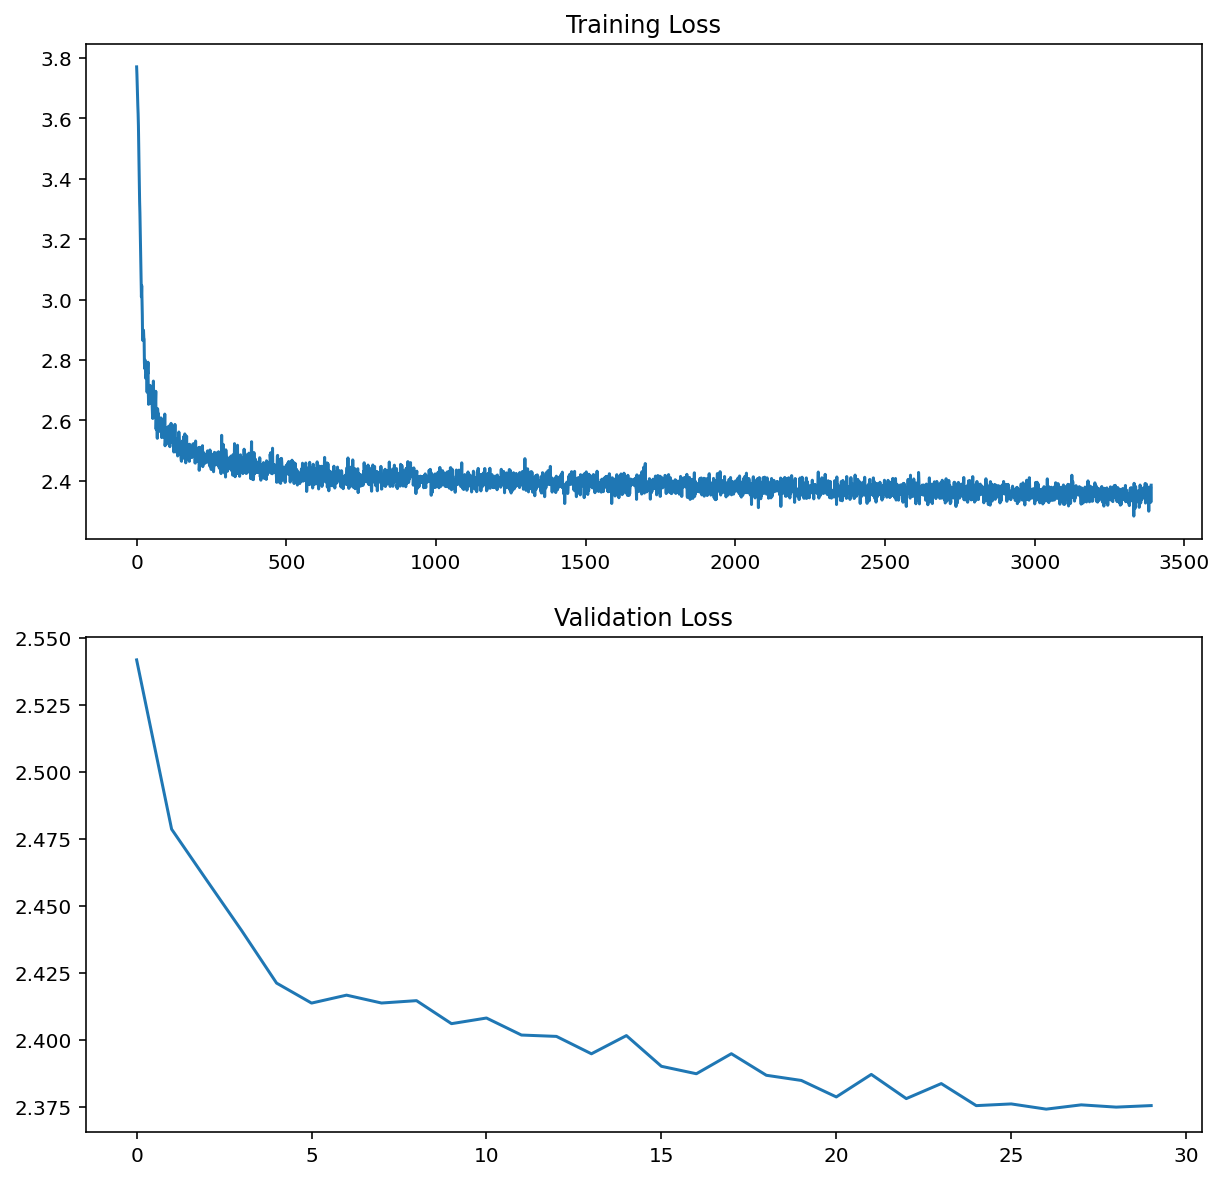

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Training Loss')
plt.plot(loss_record)
plt.subplot(2,1,2)
plt.title('Validation Loss')
plt.plot(valid_loss_record)

In [53]:
torch.save(model, './models/MIR_HW3.pt')

## Problem 7: Implement Generation (25 pts)
- In this problem, you have to generate a new melody using the trained model
- Melody language model can generate a new sequence by sampling a new note for each timestep, and feed the generated new note again to the model to predict the next note



### Problem 7-1: Implement model inference (15 pts)
- Inference in Language model is little bit different from an ordniary forward loop during the training.
    - While training, you have entire sequence, from beginning to end.
    - During the inference, you have to generate one note, and then feed it as an input for the next step
- You have to implement given functions one by one to complete `generate()`

In [99]:
def get_initial_input_and_hidden_state(model, batch_size=1):
  '''
  This function generates initial input vector and hidden state for model's GRU
  
  To generate a new sequence, you have to provide initial seed token, which is ['start', 'start'].
  You have to make a initial vector that has [pitch_category_index_of_'start', duration_category_index_of_'start']
  
  You also have to initial hidden state for the model's RNN.
  In uni-directional RNN(or GRU), hidden state of RNN has to be a zero tensor with shape of (num_layers, batch_size, hidden_size)

  
  Argument:
    model (MelodyLanguageModel)
    
  Returns:
    initial_input_vec (torch.Tensor): Has a shape of [batch_size, 1 (timestep), 2]
    initial_hidden (torch.Tensor): Has a shape of [num_layers, bach_size, hidden_size]
    
  TODO: Complete this function
  
  이 함수는 모델의 GRU에 대한 초기 입력 벡터와 숨겨진 상태를 생성합니다.
  
  새 시퀀스를 생성하려면 초기 시드 토큰(['start', 'start'])을 제공해야 합니다.
  초기 벡터는 [pitch_category_index_of_'start', duration_category_index_of_'start']로 만들어야 합니다.
  
  모델의 RNN에 대한 초기 숨김 상태도 지정해야 합니다.
  단방향 RNN(또는 GRU)에서 RNN의 숨겨진 상태는 (num_layers, batch_size, hidden_size)의 모양을 가진 0 텐서여야 합니다.

  '''
  initial_token = [[model.pitch2idx['start'], model.dur2idx['start']]]
  initial_input_vec = torch.Tensor([initial_token]*batch_size)

  initial_hidden = torch.zeros((model.num_layers, batch_size, model.hidden_size))
  return initial_input_vec, initial_hidden

batch_size = 2
input_vec, initial_hidden = get_initial_input_and_hidden_state(model, batch_size=batch_size)
print(f'input_vec: \n{input_vec} \n initial_hidden: \n {initial_hidden}')

assert input_vec.ndim == 3
assert initial_hidden.ndim == 3
assert input_vec.shape == (batch_size, 1, 2)
assert initial_hidden.shape == (model.num_layers, batch_size, model.hidden_size)

input_vec: 
tensor([[[38., 44.]],

        [[38., 44.]]]) 
 initial_hidden: 
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

### Hint: Sampling from distribution
- The language model predict probability distribution of pitch and duration for  upcoming note
- To do that, you have to know how to sample a result from a given probability distribution
- In PyTorch, you can use `atensor.multinomial(num_samples)`
    - In this assignment you don't have to sample more than 1, but 
    - multinomial(num_samples=100, replacement=False) means that you want to sample 100 samples without overlapping category
        - Thus, the total class has to be larger than 100, because you cannot sample a single category multiple time
    - multinomial(num_samples=100, replacement=True) means that you will sample 100 from the distrubtion independently

In [100]:
from collections import Counter
'''
Example of sampling a result from a given probability distribution
'''

dummy_prob_distribution = torch.Tensor([0.1, 0.5, 0.2, 0.05, 0.15])
sampled_out = dummy_prob_distribution.multinomial(num_samples=10000, replacement=True)
print(sampled_out[:20])
Counter(sampled_out.tolist()) # Number of each category sampled is almost same as num_samples * probability

tensor([1, 1, 1, 3, 1, 2, 4, 2, 4, 4, 1, 1, 2, 4, 1, 4, 1, 1, 1, 4])


Counter({1: 4948, 3: 479, 2: 2073, 4: 1490, 0: 1010})

In [101]:
def predict_single_step(model, cur_input, prev_hidden):
  '''
  This function runs MelodyLangaugeModel just for one step, for the given current input and previous hidden state.
  
  Arguments:
    model (MelodyLanguageModel)
    cur_input (torch.LongTensor): Input for the current time step. Has a shape of (batch_size=1, 1 (timestep), 2)
    prev_hidden (torch.Tensor): Hidden state of RNN after previous timestep

  Returns:
    cur_output (torch.LongTensor): Sampled note [pitch_category_idx, duration_category_idx] from the predicted probability distribution, with shape of [1,1,2]
    last_hidden (torch.Tensor): Hidden state of RNN
  Think about running the model.forward() step-by-step.
  
  input_seq → self.get_concat_embedding → self.rnn → self.final_layer → torch.softmax for [pitch, duration] → sampled [pitch, duration]

  '''
  return 

input_vec, initial_hidden = get_initial_input_and_hidden_state(model, batch_size=1)
out_note, last_hidden = predict_single_step(model, input_vec, initial_hidden)
print(f'out_note: \n{out_note} \n last_hidden: \n {last_hidden}')

assert out_note.ndim == 3
assert last_hidden.ndim == 3
assert out_note.shape == (1,1,2)

assert len(set([predict_single_step(model, input_vec, initial_hidden)[0] for i in range(5)]))==5, 'Generated output has to be different based on random sampling'

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
def is_end_token(model, cur_output):
  '''
  During the generation, there is a possibility that the generated note predicted 'end' token for either pitch or duration.
  (In fact, model can even estimate 'start' token during the generation even though it has very low probability)
  
  Using information among (model.pitch2idx, model.dur2idx, model.idx2pitch, model.idx2dur, model.num_pitch, model.num_dur), check whether 
  
  Arguments:
    model (MelodyLanguageModel)
    cur_output (torch.LongTensor): Assume it has shape of [1,1,2 (pitch_idx, duration_idx)]
  
  Return:
    is_end_token (bool): True if cur_output include category index such as 'start' or 'end',
                          else False.
                          
  TODO: Complete this function
  '''
  
  
  return 


print(is_end_token(model, out_note))

assert not is_end_token(model, torch.LongTensor([[[10, 7]]]))
assert is_end_token(model, torch.LongTensor([[[38, 40]]]))
assert is_end_token(model, torch.LongTensor([[[25, 44]]]))
assert is_end_token(model, torch.LongTensor([[[39, 41]]]))

In [ ]:
model.cpu()

def generate(model, random_seed=0):
  '''
  This function generates a new melody sequence with a given model and random_seed.
  
  Arguments:
    model (MelodyLanguageModel)
    random_seed (int): Language model's inference will always generate different result, because it uses random sampling for the prediction.
                       Therefore, if you want to reproduce the same generation result, you have to fix random_seed.
  
  Returns:
    generated_note_sequence (torch.LongTensor): Has a shape of [num_generated_notes, 2]
  
  TODO: Complete this function using get_initial_input_and_hidden_state(), predict_single_step(), is_end_token()
  
  Hint: You can use while loop
        You have to track the generated single note in a list or somewhere. 
  '''
  
  torch.manual_seed(random_seed) # To reproduce the result, we have to control random sequence
  
  '''
  Write your code from here
  '''

  return
gen_out = generate(model)
print(f"gen_out: \n {gen_out}")

assert isinstance(gen_out, torch.LongTensor), f"output of generate() has to be torch.LongTensor, not {type(gen_out)}"
assert gen_out.ndim == 2, f"output of generate() has to be 2D tensor, not {gen_out.ndim}D tensor"
assert gen_out.shape[1] == 2

### Problem 7-2. Convert neural network's prediction to music score (10 pts)
- Even though neural network has succeeded in generating a new sequence, it is just a sequence of index that neural network uses
    - For example, generated note event [17, 10] means that this note has pitch value of 17th pitch category and duration value of 10th duration category
- We have to convert categorical index to original value
    - We saved this information as `idx2pitch`, `idx2dur` while we declared the dataset

In [ ]:
def convert_idx_pred_to_origin(pred:torch.Tensor, idx2pitch:list, idx2dur:list):
  '''
  This function convert neural net's output index to original pitch value (MIDI Pitch) and duration value 
  
  Argument:
    pred: generated output of the model. Has a shape of [num_notes, 2]. 
          0th dimension of each note represents pitch category index 
          and 1st dimension of each note represents duration category index
  
  Return:
    converted_out (torch.Tensor): Has a same shape with 'pred'.
    
  TODO: Complete this function
  '''
    
  return 

converted_out = convert_idx_pred_to_origin(gen_out, model.idx2pitch, model.idx2dur)
assert converted_out.shape == gen_out.shape

In [ ]:
'''
To solve the next problem, you have to know how note_representation looks like in muspy.

In note representation, each note is represented as [start_timestep, pitch, duration, velocity]

'''

note_repr_example = train_set.dataset[0]
note_repr_example

In [ ]:
def convert_pitch_dur_to_note_representation(pitch_dur:torch.LongTensor):
  '''
  This function takes pitch_dur (shape of [num_notes, 2]) and returns the corresponding note representation (shape of [num_notes, 4])
  In note representation, each note is represented as [start_timestep, pitch, duration, velocity]
  
  Since our generation is monophonic, you can regard start_timestep starts from 0 and accumulate the duration of note.
  You can fix velocity to 64.
  
  
  Arguments:
    pitch_dur: LongTensor of note where each note represented as pitch and duration value
    
  return:
    note_repr: numpy.Array with shape of [num_notes, 4]
               each note has value of [start_timestep, pitch, duration, velocity]

  TODO: Complete this function
  Hint: You can use torch.cumsum() to accumulate the duration.
  To convert torch tensor to numpy, you can use atensor.numpy()
  
  '''
  
  return 

note_repr = convert_pitch_dur_to_note_representation(converted_out)
note_repr

## Generation: Visualize and synthesize the generated result (10 pts)
- Try to generate different melody using different `random_seed`
- In your submission, include **Three** examples of your favorite among the generated results in wav
    - You have to install soundfont and music font using 
        - `muspy.download_bravura_font()`
        - `muspy.download_musescore_soundfont()`
    - You may need fluidsynth to synthesize the sound.
        - In colab, `!sudo apt-get install fluidsynth` will work
        - In other Ubuntu os, `sudo apt-get update` and then `sudo apt-get install fluidsynth` will work

In [ ]:
import IPython.display as ipd

gen_music = muspy.from_note_representation(note_repr)
gen_music.show_score()

gen_audio = gen_music.synthesize().T
ipd.Audio(gen_audio/2**15, rate=44100)

- Try with different random seed and generate interesting melodies

In [ ]:

def generate_muspy_music(model, random_seed=0):
  '''
  This function combines 'generate', 'convert_idx_pred_to_origin', 'convert_pitch_dur_to_note_representation', muspy.from_note_representation
  '''
  gen_out = generate(model, random_seed)
  converted_out = convert_idx_pred_to_origin(gen_out, model.idx2pitch, model.idx2dur)
  note_repr = convert_pitch_dur_to_note_representation(converted_out)
  gen_music = muspy.from_note_representation(note_repr)
  return gen_music

gen_music = generate_muspy_music(model, random_seed=2)
gen_music.show_score()
gen_audio = gen_music.synthesize().T
ipd.Audio(gen_audio/2**15, rate=44100)

In [ ]:
'''
You can save audio as wave file with muspy.write_audio
'''
gen_music.write_audio('result_0.wav')